In [2]:
from utils import *
from models import *
from train import *

In [3]:
dataloader_train, dataloader_val, dataloader_test = load_data()

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BERTClassifier(num_classes=3).to(device)
print([name for name, param in model.named_parameters() if param.requires_grad]) # check that the BERT parameters are well frozen
learning_rate = 1e-4
num_epochs = 1
patience=5

['decoder.query_proj.weight', 'decoder.query_proj.bias', 'decoder.key_proj.weight', 'decoder.key_proj.bias', 'decoder.value_proj.weight', 'decoder.value_proj.bias', 'decoder.attention.in_proj_weight', 'decoder.attention.in_proj_bias', 'decoder.attention.out_proj.weight', 'decoder.attention.out_proj.bias', 'decoder.layer_norm.weight', 'decoder.layer_norm.bias', 'decoder.fc.weight', 'decoder.fc.bias']


100%|██████████| 25/25 [00:45<00:00,  1.83s/it]


Epoch [1/1], Train Loss: 0.9987, Valid Loss: 0.9308, Valid Accuracy: 0.5303, Valid F1 score: 0.5220


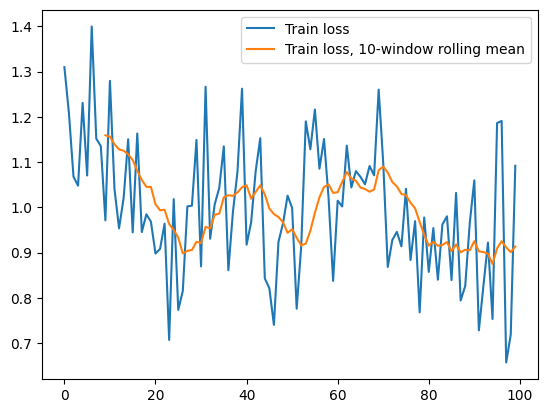

Validation loss improved, saving model...



In [6]:
train(device, dataloader_train, dataloader_val, model, learning_rate, num_epochs, patience, experiment_name='check')

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BERTClassifier(num_classes=3).to(device)
print([name for name, param in model.named_parameters() if param.requires_grad]) # check that the BERT parameters are well frozen
learning_rate = 1e-4
num_epochs = 1
patience=5

['decoder.query_proj.weight', 'decoder.query_proj.bias', 'decoder.key_proj.weight', 'decoder.key_proj.bias', 'decoder.value_proj.weight', 'decoder.value_proj.bias', 'decoder.attention.in_proj_weight', 'decoder.attention.in_proj_bias', 'decoder.attention.out_proj.weight', 'decoder.attention.out_proj.bias', 'decoder.layer_norm.weight', 'decoder.layer_norm.bias', 'decoder.fc.weight', 'decoder.fc.bias']


In [8]:
train(device, dataloader_train, dataloader_val, model, learning_rate, num_epochs, patience, add_sparsity_penalty=True, experiment_name='check_sparsity_penalty')

  2%|▏         | 2/100 [00:03<02:54,  1.79s/it]

KeyboardInterrupt



In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = HardThresholdingBERTClassifier(num_classes=3).to(device)
print([name for name, param in model.named_parameters() if param.requires_grad]) # check that the BERT parameters are well frozen
learning_rate = 1e-4
num_epochs = 1
patience=5

In [ ]:
train(device, dataloader_train, dataloader_val, model, learning_rate, num_epochs, patience, experiment_name='check_hardthresholding')

In [10]:
model = BERTClassifier(num_classes=3).to(device)
model.load_decoder_weights('best_model.pt')
model.eval()

BERTClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

In [25]:
pred = []
true = labels_test.numpy()
all_cls_attn_weights = []
for input_ids, attention_masks, labels in tqdm(dataloader_test):
    input_ids = input_ids.to(device)
    attention_masks = attention_masks.to(device)
    labels = labels.to(device)   
    with torch.no_grad():
        outputs, cls_attn_weights = model(input_ids=input_ids, attention_mask=attention_masks)
        pred.append(outputs.argmax(dim=1).numpy())
        all_cls_attn_weights.append(cls_attn_weights.numpy())
# test_ce = test_ce / len(dataset_test)
# test_accuracy = test_accuracy/ len(dataset_test)
# test_f1 = f1_score(actual.cpu().detach().numpy(), pred.cpu().detach().numpy(), average='weighted')

100%|██████████| 31/31 [00:39<00:00,  1.28s/it]


In [26]:
test

,sentence,label
0,The U. S. international trade deficit narrowed...,0
1,"Based on historical experience, it seems impro...",0
2,This was also an era when the principal mortga...,2
3,The available data for October suggested that ...,2
4,"However, we have also found that excluding vol...",2
...,...,...
491,"Over the medium term, participants expected st...",0
492,"If so, GDP growth this calendar year could be ...",1
493,Several participants discussed the possible co...,1
494,"Looking ahead, FOMC participants project the u...",2


In [27]:
# Concatenate across batches
pred = np.concatenate(pred, axis=0)
cls_attn_weights = np.concatenate(all_cls_attn_weights, axis=0)

In [28]:
(pred == true).mean()

0.5685483870967742

In [29]:
# il faut masquer et enlever la connexion résiduelle
cls_attn_weights[0].argmax(axis=1)

array([28, 28, 11, 11, 27, 27, 11, 11])

In [32]:
tokenizer.convert_ids_to_tokens(input_ids_test[0])

['[CLS]',
 'the',
 'u',
 '.',
 's',
 '.',
 'international',
 'trade',
 'deficit',
 'narrowed',
 'in',
 'may',
 ',',
 'as',
 'a',
 'large',
 'increase',
 'in',
 'exports',
 'of',
 'goods',
 'and',
 'services',
 'more',
 'than',
 'offset',
 'a',
 'moderate',
 'increase',
 'in',
 'imports',
 '.',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PA

In [34]:
pred

array([1, 2, 0, 2, 2, 2, 0, 0, 0, 1, 2, 2, 1, 2, 1, 1, 0, 0, 0, 2, 2, 0,
       2, 2, 0, 2, 2, 0, 2, 0, 0, 2, 2, 1, 2, 2, 1, 0, 2, 2, 2, 2, 0, 2,
       2, 2, 2, 1, 2, 2, 2, 2, 2, 0, 0, 2, 2, 1, 2, 1, 2, 0, 2, 0, 0, 2,
       2, 2, 2, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0,
       0, 1, 2, 2, 0, 2, 2, 0, 2, 2, 2, 2, 2, 0, 0, 2, 2, 1, 0, 0, 2, 2,
       0, 1, 0, 0, 0, 2, 2, 0, 2, 0, 0, 2, 0, 2, 2, 0, 2, 1, 1, 1, 0, 0,
       2, 2, 2, 0, 1, 0, 0, 0, 2, 2, 1, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2,
       2, 2, 2, 0, 2, 2, 2, 1, 0, 2, 0, 2, 2, 2, 1, 0, 1, 2, 2, 2, 0, 0,
       1, 0, 2, 0, 0, 2, 2, 0, 2, 2, 0, 2, 1, 2, 2, 0, 2, 0, 0, 1, 2, 1,
       2, 2, 0, 0, 2, 2, 1, 2, 0, 0, 2, 2, 1, 0, 2, 1, 2, 0, 0, 2, 2, 2,
       2, 1, 0, 0, 0, 0, 2, 1, 2, 2, 1, 0, 2, 0, 2, 2, 0, 2, 0, 2, 2, 2,
       1, 0, 2, 0, 2, 0, 0, 1, 2, 2, 0, 1, 2, 2, 0, 2, 1, 2, 0, 2, 0, 2,
       2, 2, 0, 1, 2, 2, 2, 0, 1, 0, 0, 2, 0, 0, 0, 2, 2, 2, 2, 1, 0, 0,
       0, 2, 0, 2, 2, 0, 1, 0, 2, 2, 0, 2, 0, 2, 2,

In [36]:
true

array([0, 0, 2, 2, 2, 2, 0, 0, 1, 2, 2, 2, 1, 0, 1, 0, 2, 1, 1, 0, 1, 0,
       2, 2, 0, 1, 0, 0, 0, 0, 1, 2, 2, 2, 2, 2, 1, 0, 0, 2, 2, 1, 0, 2,
       2, 2, 2, 1, 2, 2, 2, 1, 1, 1, 2, 1, 2, 1, 2, 2, 2, 2, 2, 0, 2, 2,
       2, 1, 0, 2, 2, 2, 0, 2, 1, 2, 1, 0, 1, 0, 2, 2, 2, 2, 2, 2, 1, 2,
       2, 2, 2, 2, 0, 0, 2, 0, 2, 0, 2, 0, 1, 2, 0, 1, 2, 2, 0, 0, 2, 2,
       0, 1, 2, 2, 0, 2, 0, 1, 2, 0, 1, 2, 0, 2, 0, 2, 0, 1, 1, 2, 0, 0,
       2, 1, 2, 1, 1, 0, 0, 2, 2, 2, 1, 2, 2, 0, 0, 2, 2, 0, 2, 2, 1, 2,
       2, 2, 1, 2, 2, 2, 1, 2, 0, 2, 1, 0, 0, 2, 0, 2, 1, 2, 1, 2, 2, 1,
       1, 1, 2, 0, 0, 2, 2, 2, 0, 2, 0, 2, 1, 2, 2, 2, 2, 0, 0, 1, 2, 2,
       2, 0, 1, 1, 2, 2, 0, 2, 1, 1, 0, 2, 2, 1, 2, 2, 2, 0, 0, 2, 2, 0,
       1, 2, 1, 0, 0, 1, 1, 1, 0, 1, 2, 2, 1, 2, 2, 2, 1, 2, 0, 2, 2, 2,
       1, 1, 2, 1, 2, 2, 0, 1, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 0, 2, 0, 2,
       2, 2, 0, 1, 1, 2, 2, 2, 1, 0, 2, 2, 2, 2, 2, 2, 1, 2, 0, 1, 0, 1,
       0, 2, 1, 2, 0, 0, 1, 0, 2, 2, 0, 0, 0, 2, 2,

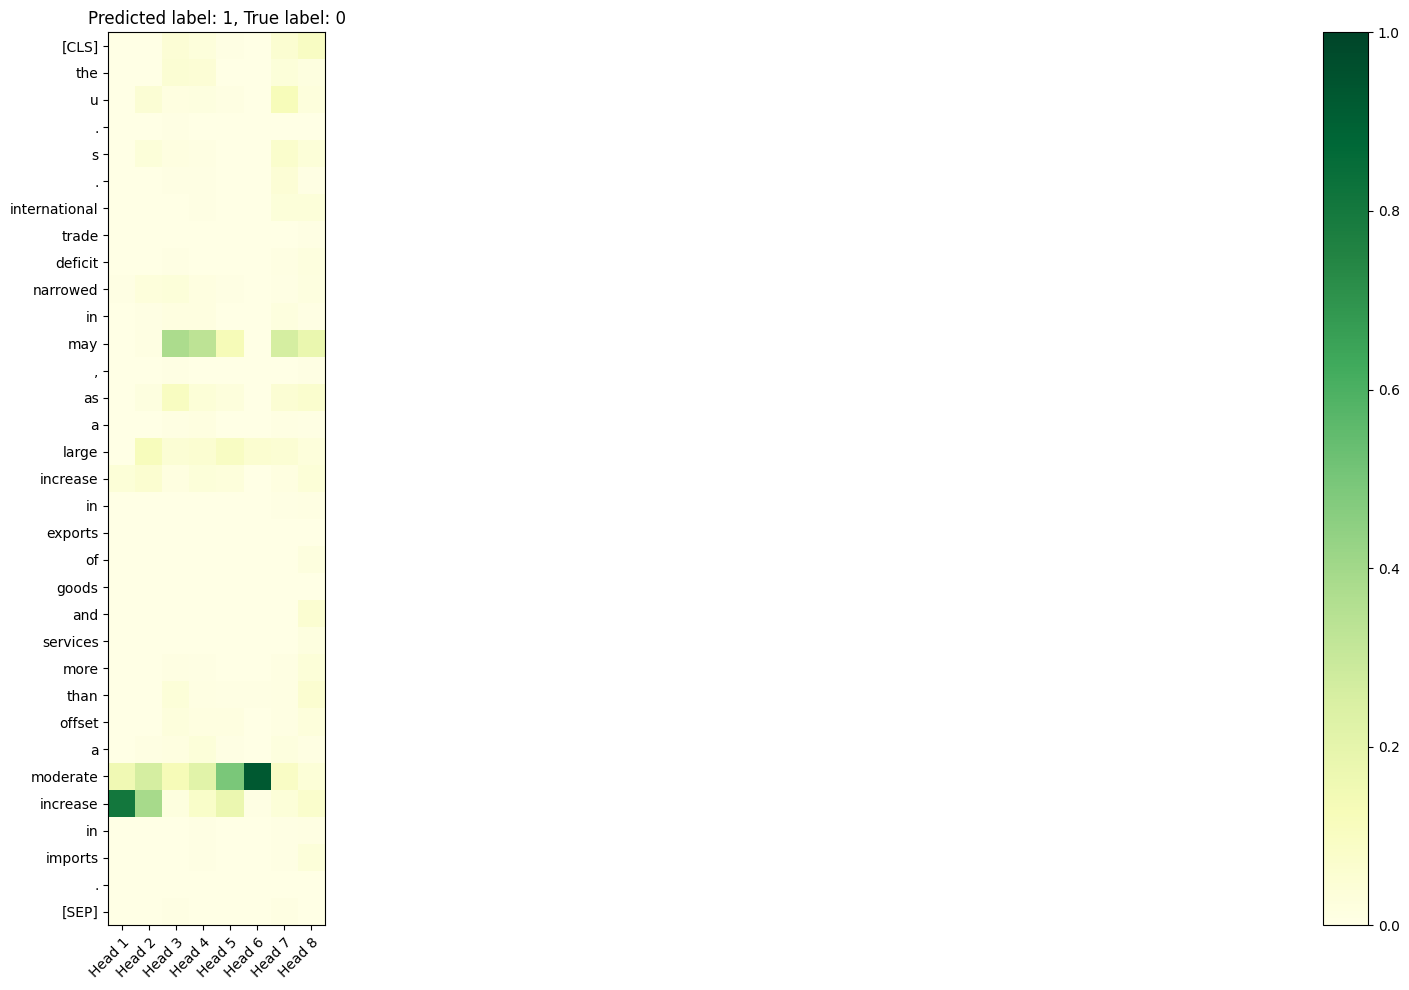

In [33]:
sentence = [tok for tok in tokenizer.convert_ids_to_tokens(input_ids_test[0]) if tok != '[PAD]']
sentence_length = len(sentence) 
heads = [f'Head {i}' for i in range(1, 9)]
cls_weights = cls_attn_weights[0, :, :sentence_length].T

fig, ax = plt.subplots(figsize=(200, 10))
im = ax.imshow(cls_weights, cmap="YlGn", vmin=0, vmax=1)

# Create colorbar
cbar = ax.figure.colorbar(im, ax=ax)
# cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

# Show all ticks and label them with the respective list entries
ax.set_xticks(range(len(heads)), labels=heads,
              rotation=45, ha="right", rotation_mode="anchor")
ax.set_yticks(range(len(sentence)), labels=sentence)

# fig.suptitle('Example of well classified sentence')
ax.set_title(f"Predicted label: {pred[0]}, True label: {labels_test[0]}")
fig.tight_layout()
plt.show()

In [ ]:
# Faire une prédiction sur le test et récupérer les poids d'attention

In [ ]:
# Il faut faire un plt.imshow pour visualiser les poids d'attention facilement